In [ ]:
# reference taken from
# https://www.pyimagesearch.com/2017/11/06/deep-learning-opencvs-blobfromimage-works/
# https://www.tensorflow.org/api_docs/python/tf/keras/applications/MobileNetV2
# https://keras.io/api/applications/mobilenet/
# https://www.pyimagesearch.com/2020/05/04/covid-19-face-mask-detector-with-opencv-keras-tensorflow-and-deep-learning/

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer

In [3]:
from sklearn.model_selection import train_test_split

Load the data set

In [4]:
dataset= r'/content/gdrive/MyDrive/dataset'
image_directory=list(paths.list_images(dataset))

In [ ]:
image_directory

Initialize features and Tragets  and converting them into numpy arrays

In [6]:
features=[]
Targets=[]

for image in image_directory:
    label=image.split(os.path.sep)[-2]
    Targets.append(label)
    image=load_img(image,target_size=(224,224))
    image=img_to_array(image)
    image=preprocess_input(image)
    features.append(image)

In [7]:
features

[array([[[-0.94509804, -0.9764706 , -0.85882354],
         [-0.94509804, -0.9764706 , -0.85882354],
         [-0.94509804, -0.9764706 , -0.85882354],
         ...,
         [-0.8509804 , -0.90588236, -0.78039217],
         [-0.8509804 , -0.90588236, -0.78039217],
         [-0.84313726, -0.8980392 , -0.77254903]],
 
        [[-0.9137255 , -0.94509804, -0.827451  ],
         [-0.9137255 , -0.94509804, -0.827451  ],
         [-0.9137255 , -0.94509804, -0.827451  ],
         ...,
         [-0.7647059 , -0.79607844, -0.6784314 ],
         [-0.7647059 , -0.79607844, -0.6784314 ],
         [-0.75686276, -0.7882353 , -0.67058825]],
 
        [[-0.92156863, -0.9607843 , -0.8039216 ],
         [-0.92156863, -0.9607843 , -0.8039216 ],
         [-0.92156863, -0.9607843 , -0.8039216 ],
         ...,
         [-0.88235295, -0.8980392 , -0.7882353 ],
         [-0.8666667 , -0.88235295, -0.77254903],
         [-0.85882354, -0.8745098 , -0.7647059 ]],
 
        ...,
 
        [[ 0.3803922 , -0.9607843 

In [ ]:
#Targets

In [8]:
features=np.array(features,dtype='float32')
Targets=np.array(Targets)

In [9]:
features.shape

(1376, 224, 224, 3)

In [10]:
Targets

array(['without_mask', 'without_mask', 'without_mask', ..., 'with_mask',
       'with_mask', 'with_mask'], dtype='<U12')

Performing One-hot encoding on the Targets(Labels)

In [11]:
label_binarizer=LabelBinarizer()
Targets=label_binarizer.fit_transform(Targets)
Targets=to_categorical(Targets)

In [12]:
Targets

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

Partitioning the traing and testing data into Train, test split of 80-20% respectivily

In [13]:
X_train,X_test,y_train,y_test=train_test_split(features,Targets,test_size=0.20,stratify=Targets,random_state=42)

In [14]:
X_train.shape

(1100, 224, 224, 3)

In [15]:
y_train.shape

(1100, 2)

In [16]:
X_test.shape

(276, 224, 224, 3)

In [17]:
y_test.shape

(276, 2)

Data Augumentation 

In [18]:
IMAGE_SIZE =224

Datagen=ImageDataGenerator(rotation_range=20,
                       zoom_range=0.15,
                       width_shift_range=0.2,
                       height_shift_range=0.2,
                       shear_range=0.15,
                       horizontal_flip=True,
                       vertical_flip=True,
                       fill_mode='nearest')

Construct the MobileNetV2 Model to perform training

In [19]:
# load the MobileNetV2 network, and consider weights as imagenet
First_block_Model = MobileNetV2(weights='imagenet', include_top=False,input_tensor = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
First_block_Model.summary()


9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
________________

In [20]:
# construct the head of the model that will be placed a top layer of the the base model
Last_block_Model = First_block_Model.output
Last_block_Model = AveragePooling2D(pool_size=(7, 7))(Last_block_Model)
Last_block_Model = Flatten(name="flatten")(Last_block_Model)
Last_block_Model = Dense(128, activation="relu")(Last_block_Model)
Last_block_Model = Dropout(0.5)(Last_block_Model)
Last_block_Model = Dense(2, activation="softmax")(Last_block_Model)

In [21]:
# place the head of the First Convolution model on top of the base model 
model = Model(inputs=First_block_Model.input, outputs=Last_block_Model)

In [22]:
# loop over all layers in the base model and freeze the weights
for layer in First_block_Model.layers:
	layer.trainable = False

In [23]:
Learning_rate = 1e-4
EPOCHS = 20
BatchSize = 32

Compile the model using Adam Optimizer

In [24]:
Optimizer = Adam(lr=Learning_rate, decay=Learning_rate / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=Optimizer,
	metrics=["accuracy"])

Fit the model for 20 epochs

In [26]:
History = model.fit(
	Datagen.flow(X_train, y_train, batch_size=BatchSize),
	steps_per_epoch=len(X_train) // BatchSize,
	validation_data=(X_test, y_test),
	validation_steps=len(X_test) // BatchSize,
	epochs=20)


Epoch 1/20
34/34 [==============================] - 52s 2s/step - loss: 0.5856 - accuracy: 0.7191 - val_loss: 0.1538 - val_accuracy: 0.9783
Epoch 2/20
34/34 [==============================] - 51s 1s/step - loss: 0.2495 - accuracy: 0.9036 - val_loss: 0.0785 - val_accuracy: 0.9855
Epoch 3/20
34/34 [==============================] - 51s 1s/step - loss: 0.1768 - accuracy: 0.9401 - val_loss: 0.0561 - val_accuracy: 0.9928
Epoch 4/20
34/34 [==============================] - 51s 2s/step - loss: 0.1327 - accuracy: 0.9504 - val_loss: 0.0448 - val_accuracy: 0.9928
Epoch 5/20
34/34 [==============================] - 51s 2s/step - loss: 0.1217 - accuracy: 0.9607 - val_loss: 0.0398 - val_accuracy: 0.9928
Epoch 6/20
34/34 [==============================] - 51s 2s/step - loss: 0.0962 - accuracy: 0.9644 - val_loss: 0.0357 - val_accuracy: 0.9928
Epoch 7/20
34/34 [==============================] - 51s 2s/step - loss: 0.0966 - accuracy: 0.9719 - val_loss: 0.0319 - val_accuracy: 0.9928
Epoch 8/20
34/34 [==

Evaluating the model on test data set

In [89]:
predict_model=model.predict(X_test,batch_size=BatchSize)

Printing the classification matrics

In [90]:
from sklearn.metrics import classification_report

predict_model=np.argmax(predict_model,axis=1)
print(classification_report(y_test.argmax(axis=1),predict_model,target_names=label_binarizer.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       138
without_mask       0.99      0.99      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



In [91]:
model.save("mask_detector.model.h5")


Accuracy and Epochs Plot

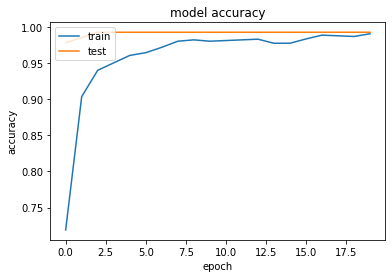

In [29]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Loss and Epochs Plot

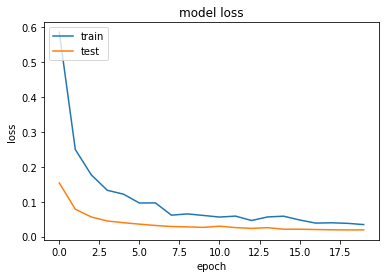

In [30]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Testing our model on image

In [32]:
model =load_model("mask_detector.model.h5")

To perform testing using opencv deploy.prototxt and res10_300x300_ssd_iter_140000.caffemodel is required

download the image to be tested

In [42]:
from google.colab import files

uploaded = files.upload()

Saving image.jpg to image.jpg


In [43]:
import cv2

Get the deploy.prototxt from the github repositiory of opencv

In [56]:
! wget https://raw.githubusercontent.com/opencv/opencv/3.4.0/samples/dnn/face_detector/deploy.prototxt

--2020-12-09 13:31:23--  https://raw.githubusercontent.com/opencv/opencv/3.4.0/samples/dnn/face_detector/deploy.prototxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28092 (27K) [text/plain]
Saving to: ‘deploy.prototxt’

deploy.prototxt     100%[===================>]  27.43K  --.-KB/s    in 0s      

2020-12-09 13:31:23 (54.8 MB/s) - ‘deploy.prototxt’ saved [28092/28092]



Download the res10_300x300_ssd_iter_140000.caffemodel model form OpenCV website and uploaded here

In [57]:
from google.colab import files

uploaded = files.upload()

Saving res10_300x300_ssd_iter_140000.caffemodel to res10_300x300_ssd_iter_140000.caffemodel


Loading the models

In [58]:
prototxtPath=os.path.sep.join([r'deploy.prototxt'])

In [59]:
weightsPath = os.path.sep.join([r'res10_300x300_ssd_iter_140000.caffemodel'])

Read the image and get theh height and width

In [60]:
net=cv2.dnn.readNet(prototxtPath,weightsPath)

In [142]:
input_file_path = "/content/gdrive/My Drive/image.jpg"

In [143]:
def process_images(input_file_path):
  image = cv2.imread(input_file_path)
image


array([[[113, 139, 156],
        [113, 139, 156],
        [113, 139, 156],
        ...,
        [130, 154, 176],
        [127, 151, 173],
        [124, 148, 170]],

       [[114, 140, 157],
        [114, 140, 157],
        [114, 140, 157],
        ...,
        [132, 156, 178],
        [129, 153, 175],
        [126, 150, 172]],

       [[114, 140, 157],
        [114, 140, 157],
        [114, 140, 157],
        ...,
        [133, 157, 179],
        [131, 154, 176],
        [128, 151, 173]],

       ...,

       [[164, 231, 240],
        [164, 231, 240],
        [164, 231, 240],
        ...,
        [150, 214, 244],
        [149, 215, 244],
        [149, 215, 244]],

       [[164, 231, 240],
        [164, 231, 240],
        [164, 231, 240],
        ...,
        [148, 214, 243],
        [148, 214, 243],
        [148, 214, 243]],

       [[164, 231, 240],
        [164, 231, 240],
        [165, 232, 241],
        ...,
        [147, 213, 242],
        [147, 213, 242],
        [147, 213, 242]]

In [144]:
(height,width)=image.shape[:2]

In [145]:
(height,width)

(168, 300)

**Preprocessing** --  cv2.dnnblob from image creates 4-dimensional blob from image. Optionally resizes and crops image from center, subtract mean values, scales values by scalefactor, swap Blue and Red channels.

In [146]:
blob_image=cv2.dnn.blobFromImage(image,1.0,(300,300),(104.0,177.0,123.0))

In [147]:
blob_image

array([[[[  9.,   9.,   9., ...,  26.,  23.,  20.],
         [  9.,   9.,   9., ...,  27.,  24.,  21.],
         [ 10.,  10.,  10., ...,  28.,  25.,  22.],
         ...,
         [ 60.,  60.,  60., ...,  44.,  44.,  44.],
         [ 60.,  60.,  60., ...,  43.,  43.,  43.],
         [ 60.,  60.,  61., ...,  43.,  43.,  43.]],

        [[-38., -38., -38., ..., -23., -26., -29.],
         [-38., -38., -38., ..., -22., -26., -29.],
         [-37., -37., -37., ..., -21., -24., -27.],
         ...,
         [ 54.,  54.,  54., ...,  37.,  37.,  37.],
         [ 54.,  54.,  55., ...,  36.,  36.,  36.],
         [ 54.,  54.,  55., ...,  36.,  36.,  36.]],

        [[ 33.,  33.,  33., ...,  53.,  50.,  47.],
         [ 33.,  33.,  33., ...,  53.,  50.,  47.],
         [ 34.,  34.,  34., ...,  55.,  52.,  49.],
         ...,
         [117., 117., 117., ..., 120., 120., 120.],
         [117., 117., 118., ..., 119., 119., 119.],
         [117., 117., 118., ..., 119., 119., 119.]]]], dtype=float32)

In [148]:
blob_image.shape

(1, 3, 300, 300)

Performing face detection in the image

In [149]:
net.setInput(blob_image)
faces_detections=net.forward()
faces_detections

array([[[[0.        , 1.        , 0.9994223 , ..., 0.08554843,
          0.6645167 , 0.8410299 ],
         [0.        , 1.        , 0.73997617, ..., 0.402719  ,
          1.0008916 , 1.1969717 ],
         [0.        , 1.        , 0.12667838, ..., 4.0050516 ,
          4.836229  , 4.983947  ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]]]], dtype=float32)

Get the Image ROI

In [150]:
for i in range(0,faces_detections.shape[2]):
    probability=faces_detections[0,0,i,2]

In [151]:
from google.colab.patches import cv2_imshow

In [156]:
if probability>0.5: # filter out values less than 0.5
   # compute the cordinates for creating bounding box        
        bounding_box = faces_detections[0,0,i,3:7]*np.array([width,height,width,height])
        (X_start,y_start,X_end,y_end)=bounding_box.astype('int')
        (X_start,y_start)=(max(0,X_start),max(0,y_start))
        (X_end,y_end)=(min(width-1,X_end), min(height-1,y_end))


        # extract the face ROI and convert to RGB and Resize 
        ROI_face=image[y_start:y_end, X_start:X_end]
        face_RGB=cv2.cvtColor(ROI_face,cv2.COLOR_BGR2RGB)
        face=cv2.resize(face_RGB,(224,224))
        # converting to array
        face_array=img_to_array(face)
        preproceess_face=preprocess_input(face_array)

        face=np.expand_dims(preprocess_face,axis=0)
        (mask,without_Mask)=model.predict(face)[0]

# to determine the label and class 
        Target='Mask' if mask>without_Mask else 'No Mask'

        color=(0,255,0) if Target=='Mask' else (0,0,255)

#include the probability in the label
        Target="{}: {:.2f}%".format(Target,max(mask,without_Mask)*100)
        cv2.putText(image,Target,(X_start,y_start-10),cv2.FONT_HERSHEY_SIMPLEX,0.45,color,2)
        cv2.rectangle(image,(X_start,y_start),(X_end,y_end),color,2)

save_path = input_file_path.split(".",1)
print (save_path[0]) 
print (save_path[-1])     
#cv2_imshow(image)
#cv2.waitKey()
#cv2.destroyAllWindows()
cv2.imwrite(save_path[0] + "_pred." + save_path[-1],image)
process_images(input_file_path)



/content/gdrive/My Drive/image
jpg
